In [1]:
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from random import randrange
sns.set(rc={'figure.figsize':(15,8)})

In [2]:
df = pd.read_csv("./data/abalone.data", names=["sex", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight", "rings"])

In [3]:
raw_abs = df.copy()
raw_abs

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [4]:
raw_abs.loc[raw_abs['rings'].between(0, 7,inclusive='both'), 'ring_class'] = int(1)
raw_abs.loc[raw_abs['rings'].between(8, 10,inclusive='both'), 'ring_class'] = int(2)
raw_abs.loc[raw_abs['rings'].between(11, 15,inclusive='both'), 'ring_class'] = int(3)
raw_abs.loc[raw_abs['rings'] > 15, 'ring_class'] = int(4)
raw_abs['ring_class'] = raw_abs['ring_class'].astype(int)

In [5]:
raw_abs.drop(columns = "rings", axis=1, inplace=True)


In [6]:
raw_abs = raw_abs[(raw_abs['height']<0.4) & (raw_abs['height']>0.01)]

# Visualisations

### Distribtion of ring class

In [7]:
raw_abs.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,ring_class
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,3
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,2
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,2
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,1


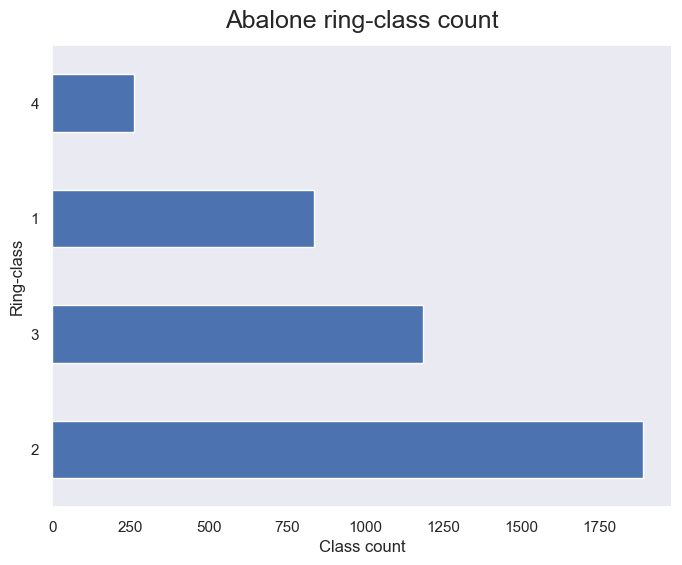

In [8]:
raw_abs['ring_class'].value_counts().plot(kind='barh', figsize=(8,6))
plt.ylabel("Ring-class")
plt.xlabel("Class count")
plt.grid(False)
plt.title("Abalone ring-class count", y=1.02, fontsize = 18);

array([[<AxesSubplot: title={'center': 'length'}>,
        <AxesSubplot: title={'center': 'diameter'}>,
        <AxesSubplot: title={'center': 'height'}>],
       [<AxesSubplot: title={'center': 'whole_weight'}>,
        <AxesSubplot: title={'center': 'shucked_weight'}>,
        <AxesSubplot: title={'center': 'viscera_weight'}>],
       [<AxesSubplot: title={'center': 'shell_weight'}>,
        <AxesSubplot: title={'center': 'ring_class'}>, <AxesSubplot: >]],
      dtype=object)

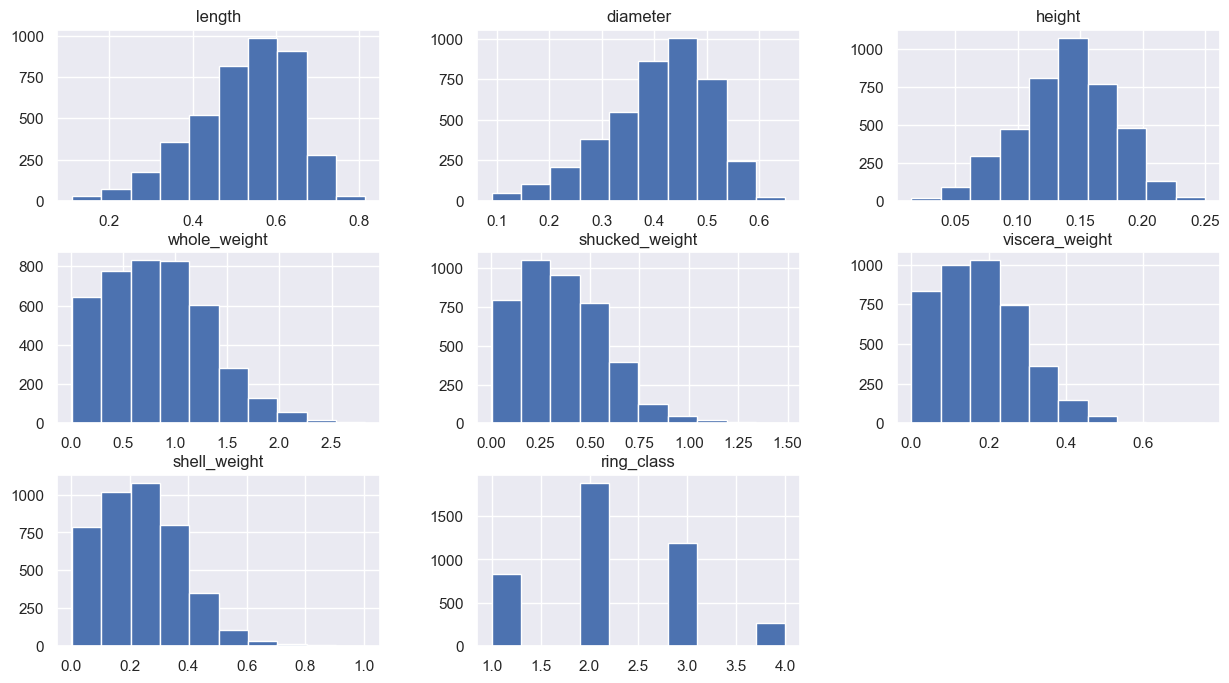

In [9]:
raw_abs.hist()

C:\Users\Dominic\AppData\Local\Temp\ipykernel_13760\313788559.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(raw_abs.corr(), annot=True, cbar=False, vmin=-1., vmax=1., cmap=sns.cm.rocket)


Text(0.5, 1.0, 'Correlation Heatmap')

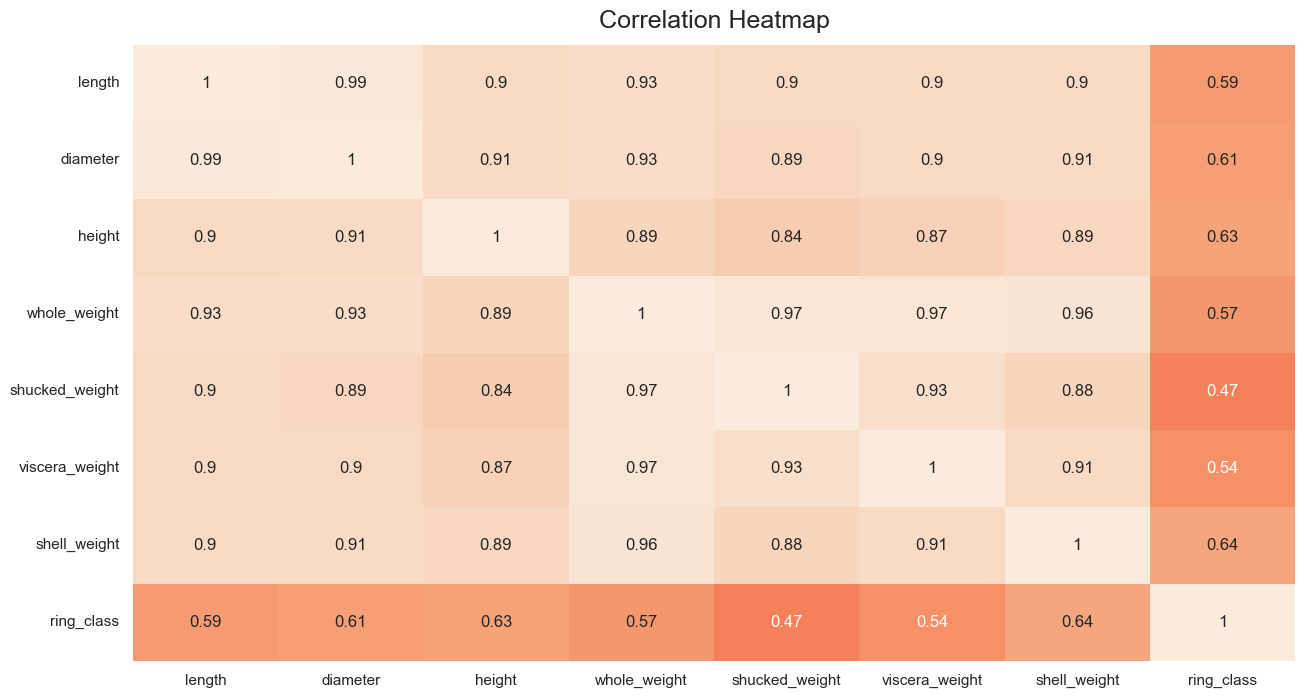

In [10]:
heatmap = sns.heatmap(raw_abs.corr(), annot=True, cbar=False, vmin=-1., vmax=1., cmap=sns.cm.rocket)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

# Building the model

In [11]:
num_pipeline = Pipeline([
    ('Nomalisation', MinMaxScaler()),
    ])

sex_pipeline = Pipeline([
    ('ord_encoder', OrdinalEncoder(categories=[['M', 'F', 'I']]))
])

ringClass_pipeline = Pipeline([
    ('ringClass_1Hot', OneHotEncoder())
])

num_arribs = list(raw_abs.drop(columns=["sex", "ring_class"]))

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_arribs),
    ("sex", sex_pipeline, ['sex']),
    ("ringClass_1Hot", ringClass_pipeline, ['ring_class'])
])



In [12]:
abs_prepared = pd.DataFrame(full_pipeline.fit_transform(raw_abs))
abs_prepared

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.489362,0.491071,0.340426,0.179592,0.149445,0.132324,0.146707,0.0,0.0,0.0,1.0,0.0
1,0.340426,0.312500,0.319149,0.077196,0.065298,0.063199,0.066866,0.0,1.0,0.0,0.0,0.0
2,0.595745,0.589286,0.510638,0.237445,0.170986,0.185648,0.206587,1.0,0.0,1.0,0.0,0.0
3,0.468085,0.491071,0.468085,0.180302,0.143386,0.149440,0.151697,0.0,0.0,1.0,0.0,0.0
4,0.312057,0.294643,0.276596,0.069920,0.058566,0.051350,0.051896,2.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4167,0.645390,0.642857,0.638298,0.311979,0.247391,0.314022,0.245509,1.0,0.0,0.0,1.0,0.0
4168,0.680851,0.625000,0.510638,0.340018,0.293840,0.281764,0.256986,0.0,0.0,1.0,0.0,0.0
4169,0.695035,0.687500,0.808511,0.414552,0.352070,0.377880,0.304391,0.0,0.0,1.0,0.0,0.0
4170,0.730496,0.705357,0.574468,0.385626,0.355772,0.342989,0.292415,1.0,0.0,1.0,0.0,0.0


In [13]:
X = abs_prepared.iloc[:,:-4]
y = abs_prepared.iloc[:,-4:]

In [14]:
model_results = []

# Single layer
def run_model(hidden_neurons, lr=0.01, experimental_runs = 10, hid_layers = 1):
    
    for expi_run in range(experimental_runs):
        
        random_seed = randrange(0,100)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.4, random_state=random_seed)

        model = keras.models.Sequential([
        keras.layers.Dense(hidden_neurons, input_shape = (8,), activation = "relu"),
        # keras.layers.Dense(32, activation = "relu"),
        keras.layers.Dense(4, activation = "softmax")
        ])

        model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.SGD(learning_rate=lr),
                metrics = ['accuracy']
                )

        history = model.fit(X_train, y_train, epochs=100, verbose=0)

        mod_eval = model.evaluate(X_test, y_test)

        model_results.append([expi_run, hidden_neurons, lr, hid_layers, mod_eval[1]])

        # if ((expi_run>10) & (max(history.history['accuracy']) >= max(model_results['max_acc']))):
        #     pd.DataFrame(history.history).plot(figsize=(8,5))
        #     plt.grid(True)
        #     plt.gca().set_ylim(0,1)
        #     plt.title(str(hid_layers) + " layer network with" + str(hidden_neurons) +" hidden nurons. LR = "+ str(lr) + " with " + str(round(history.history['accuracy'][-1], 4)*100) + " % Acc.")
        #     plt.savefig(".\\images\\" + str(hid_layers) +"_layer_" + str(hidden_neurons) +"_hidden_nur" + str(lr) + "_lr.png", bbox_inches='tight')
        #     plt.close()

list(map(lambda x: run_model(hidden_neurons = x), [5,10,15,20]))

temp_results = pd.DataFrame(model_results, columns=["iter", 'hidden', 'lr', 'layers', 'test_acc'])
sing_lay_neuron_stats = temp_results.groupby(['hidden', 'lr', 'layers'])['test_acc'].describe()

79/79 [==============================] - 0s 846us/step - loss: 0.9181 - accuracy: 0.6062


In [15]:
sing_lay_neuron_stats[sing_lay_neuron_stats['mean']== sing_lay_neuron_stats['mean'].max()]

,,,count,mean,std,min,25%,50%,75%,max
hidden,lr,layers,,,,,,,,
20,0.01,1,10.0,0.596965,0.009482,0.585863,0.590355,0.594249,0.602636,0.616214


In [16]:
model_results = []

# Single layer
def run_model(hidden_neurons, lr=0.01, experimental_runs = 10, hid_layers = 1):
    
    for expi_run in range(experimental_runs):
        
        random_seed = randrange(0,100)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.4, random_state=random_seed)

        model = keras.models.Sequential([
        keras.layers.Dense(hidden_neurons, input_shape = (8,), activation = "relu"),
        # keras.layers.Dense(32, activation = "relu"),
        keras.layers.Dense(4, activation = "softmax")
        ])

        model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.SGD(learning_rate=lr),
                metrics = ['accuracy']
                )

        history = model.fit(X_train, y_train, epochs=100, verbose=0)

        mod_eval = model.evaluate(X_test, y_test)

        model_results.append([expi_run, hidden_neurons, lr, hid_layers, mod_eval[1]])

        # if ((expi_run>10) & (max(history.history['accuracy']) >= max(model_results['max_acc']))):
        #     pd.DataFrame(history.history).plot(figsize=(8,5))
        #     plt.grid(True)
        #     plt.gca().set_ylim(0,1)
        #     plt.title(str(hid_layers) + " layer network with" + str(hidden_neurons) +" hidden nurons. LR = "+ str(lr) + " with " + str(round(history.history['accuracy'][-1], 4)*100) + " % Acc.")
        #     plt.savefig(".\\images\\" + str(hid_layers) +"_layer_" + str(hidden_neurons) +"_hidden_nur" + str(lr) + "_lr.png", bbox_inches='tight')
        #     plt.close()

list(map(lambda x: run_model(hidden_neurons = 10, lr = x), [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]))


temp_results = pd.DataFrame(model_results, columns=["iter", 'hidden', 'lr', 'layers', 'test_acc'])
lr_results = temp_results.groupby(['hidden', 'lr', 'layers'])['test_acc'].describe()

79/79 [==============================] - 0s 866us/step - loss: 1.3401 - accuracy: 0.4573


In [17]:
lr_results[lr_results['mean']== lr_results['mean'].max()]

,,,count,mean,std,min,25%,50%,75%,max
hidden,lr,layers,,,,,,,,
10,0.1,1,10.0,0.598442,0.036219,0.511182,0.58776,0.610623,0.620907,0.635383


In [18]:
model_results = []

# Single layer
def run_model(hidden_neurons=10, lr=0.01, experimental_runs = 10, hid_layers = 2):
    
    for expi_run in range(experimental_runs):
        
        random_seed = randrange(0,100)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.4, random_state=random_seed)

        model = keras.models.Sequential([
        keras.layers.Dense(hidden_neurons, input_shape = (8,), activation = "relu"),
        keras.layers.Dense(32, activation = "relu"),
        keras.layers.Dense(4, activation = "softmax")
        ])

        model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.SGD(learning_rate=lr),
                metrics = ['accuracy']
                )

        history = model.fit(X_train, y_train, epochs=100, verbose=0)

        mod_eval = model.evaluate(X_test, y_test)

        model_results.append([expi_run, hidden_neurons, lr, hid_layers, mod_eval[1]])

        # if ((expi_run>10) & (max(history.history['accuracy']) >= max(model_results['max_acc']))):
        #     pd.DataFrame(history.history).plot(figsize=(8,5))
        #     plt.grid(True)
        #     plt.gca().set_ylim(0,1)
        #     plt.title(str(hid_layers) + " layer network with" + str(hidden_neurons) +" hidden nurons. LR = "+ str(lr) + " with " + str(round(history.history['accuracy'][-1], 4)*100) + " % Acc.")
        #     plt.savefig(".\\images\\" + str(hid_layers) +"_layer_" + str(hidden_neurons) +"_hidden_nur" + str(lr) + "_lr.png", bbox_inches='tight')
        #     plt.close()

run_model()


temp_results = pd.DataFrame(model_results, columns=["iter", 'hidden', 'lr', 'layers', 'test_acc'])
two_lay_results = temp_results.groupby(['hidden', 'lr', 'layers'])['test_acc'].describe()
two_lay_results

79/79 [==============================] - 0s 851us/step - loss: 0.9041 - accuracy: 0.5938


,,,count,mean,std,min,25%,50%,75%,max
hidden,lr,layers,,,,,,,,
10,0.01,2,10.0,0.601318,0.005701,0.59345,0.598642,0.601837,0.603335,0.613419


In [19]:
model_results = []

# Single layer
def run_model(hidden_neurons=10, lr=0.01, experimental_runs = 10, hid_layers = 2):
    
    for expi_run in range(experimental_runs):
        
        random_seed = randrange(0,100)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.4, random_state=random_seed)

        model = keras.models.Sequential([
        keras.layers.Dense(hidden_neurons, input_shape = (8,), activation = "relu"),
        keras.layers.Dense(32, activation = "relu"),
        keras.layers.Dense(4, activation = "softmax")
        ])

        model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(learning_rate=lr),
                metrics = ['accuracy']
                )

        history = model.fit(X_train, y_train, epochs=100, verbose=0)

        mod_eval = model.evaluate(X_test, y_test)

        model_results.append([expi_run, hidden_neurons, lr, hid_layers, mod_eval[1]])

        # if ((expi_run>10) & (max(history.history['accuracy']) >= max(model_results['max_acc']))):
        #     pd.DataFrame(history.history).plot(figsize=(8,5))
        #     plt.grid(True)
        #     plt.gca().set_ylim(0,1)
        #     plt.title(str(hid_layers) + " layer network with" + str(hidden_neurons) +" hidden nurons. LR = "+ str(lr) + " with " + str(round(history.history['accuracy'][-1], 4)*100) + " % Acc.")
        #     plt.savefig(".\\images\\" + str(hid_layers) +"_layer_" + str(hidden_neurons) +"_hidden_nur" + str(lr) + "_lr.png", bbox_inches='tight')
        #     plt.close()

run_model()


temp_results = pd.DataFrame(model_results, columns=["iter", 'hidden', 'lr', 'layers', 'test_acc'])
two_lay_adam_results = temp_results.groupby(['hidden', 'lr', 'layers'])['test_acc'].describe()
two_lay_adam_results

79/79 [==============================] - 0s 823us/step - loss: 0.7933 - accuracy: 0.6550


,,,count,mean,std,min,25%,50%,75%,max
hidden,lr,layers,,,,,,,,
10,0.01,2,10.0,0.639257,0.011397,0.615815,0.633786,0.640974,0.646066,0.654952
